In [2]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [3]:
results_paths={}

# results_paths['context_all_trials_no_baseline_subtract'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_10ms_no_baseline_subtract_0/"
# results_paths['context_all_trials'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_0/"

# results_paths['response_all_trials_no_baseline_subtract'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_response_no_baseline_subtract_0/"
# results_paths['response_all_trials'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_0/"

# results_paths['aud_stim_all_blocks'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_all_blocks_0/"
# results_paths['aud_stim_all_blocks_baseline_subtract'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_all_blocks_baseline_subtract_0/"

# results_paths['vis_stim_all_blocks'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_all_blocks_0/"
# results_paths['vis_stim_all_blocks_baseline_subtract'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_all_blocks_baseline_subtract_0/"

# results_paths['context_500ms_bins'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_keep_units_consistent_0/"

# results_paths['context_baseline_subtract_aud_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_aud_stim_10ms_bins_10_units_0/"
# results_paths['context_no_baseline_subtract_aud_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_no_baseline_subtract_aud_stim_10ms_bins_10_units_0/"
# results_paths['context_baseline_subtract_vis_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_vis_stim_10ms_bins_10_units_0/"
# results_paths['context_no_baseline_subtract_vis_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_no_baseline_subtract_vis_stim_10ms_bins_10_units_0/"

# results_paths['response_aud_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_response_aud_stim_10ms_bins_10_units_0/"
# results_paths['response_baseline_subtract_aud_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_response_baseline_subtract_aud_stim_10ms_bins_10_units_0/"
# results_paths['response_vis_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_response_vis_stim_10ms_bins_10_units_0/"
# results_paths['response_baseline_subtract_vis_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_response_baseline_subtract_vis_stim_10ms_bins_10_units_0/"

# results_paths['aud_stim_all_blocks_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_all_blocks_10ms_bins_10_units_0/"
# results_paths['vis_stim_all_blocks_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_all_blocks_10ms_bins_10_units_0/"


# results_paths['context_vis_stim_25ms_bins'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_vis_stim_25ms_bins_10_units_0/"
# results_paths['context_aud_stim_25ms_bins'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_aud_stim_25ms_bins_10_units_0/"

# results_paths['context_vis_stim_500ms_bins'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_vis_stim_500ms_bins_10_units_0/"
# results_paths['context_aud_stim_500ms_bins'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_aud_stim_500ms_bins_10_units_0/"

# results_paths['response_aligned_decode_context_targets_only'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/response_aligned_decode_context_targets_25ms_0/"
# results_paths['response_aligned_decode_reward_targets_only'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/response_aligned_decode_reward_targets_25ms_0/"

# results_paths['response_aligned_decode_context_vis_targets_only'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/response_aligned_decode_context_vis_targets_25ms_1/"
# results_paths['response_aligned_decode_context_aud_targets_only'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/response_aligned_decode_context_aud_targets_25ms_1/"

# #25ms bins with 100ms window
# results_paths['context_vis_stim_25ms_bins_w_repeats'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_vis_stim_25ms_bin_100ms_window_w_repeats_0/"
# results_paths['context_aud_stim_25ms_bins_w_repeats'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_aud_stim_25ms_bin_100ms_window_w_repeats_0/"

# results_paths['response_aligned_decode_context_aud_targets_w_repeats'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/response_aligned_decode_context_aud_targets_25ms_bin_100ms_window_w_repeats_0/"
# results_paths['response_aligned_decode_context_vis_targets_w_repeats'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/response_aligned_decode_context_vis_targets_25ms_bin_100ms_window_w_repeats_0/"

results_paths['aud_pref_units_decode_licks']=r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_aud_pref_units_decode_licks_20260206_184343/"
results_paths['vis_pref_units_decode_licks']=r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_vis_pref_units_decode_licks_20260206_184642/"

In [4]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/performance.parquet').collect()


session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_engaged'),
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [ ]:
# session_table.select(pl.col('n_contingent_rewards').str.split(';').cast(pl.List(pl.Float64)).list.filter(pl.element() > 10).list.len().gt(4) == pl.col('is_engaged')).mean()

In [ ]:
session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
).select(
    'is_engaged',
    'n_passing_blocks',
    'is_good_behavior',
    recalc_is_good_behavior=(pl.col('is_engaged') & pl.col('n_passing_blocks').is_not_null() & pl.col('n_passing_blocks').gt(4))
).filter(pl.col('is_good_behavior') != pl.col('recalc_is_good_behavior'))

In [ ]:
sel_structure_to_count='VTA'

sel_structure_table={
    'structure':[],
    'session_id':[],
    'is_good_behavior':[],
    'is_engaged':[],
    'n_good_vis_blocks':[],
    'n_good_aud_blocks':[],
    'cross_modality_dprime_vis_blocks':[],
    'cross_modality_dprime_aud_blocks':[],
    'n_engaged_blocks':[],
    'n_contingent_rewards':[],
}

for sel_session in session_table['session_id']:
    structures_in_session=session_table.filter(pl.col('session_id')==sel_session)['areas_recorded']
    if structures_in_session[0] is not None:
        structures_in_session=structures_in_session[0].split(';')
    else:
        continue
    if sel_structure_to_count in structures_in_session:
        sel_is_good_behavior=session_table.filter(pl.col('session_id')==sel_session)['is_good_behavior'][0]
        sel_cross_modality_dprime_vis_blocks=session_table.filter(pl.col('session_id')==sel_session)['cross_modality_dprime_vis_blocks'][0].split(';')
        sel_cross_modality_dprime_aud_blocks=session_table.filter(pl.col('session_id')==sel_session)['cross_modality_dprime_aud_blocks'][0].split(';')

        sel_cross_modality_dprime_vis_blocks=np.array([float(x) for x in sel_cross_modality_dprime_vis_blocks]).round(2)
        sel_cross_modality_dprime_aud_blocks=np.array([float(x) for x in sel_cross_modality_dprime_aud_blocks]).round(2)
        n_good_vis_blocks=sum(sel_cross_modality_dprime_vis_blocks>=1.0)
        n_good_aud_blocks=sum(sel_cross_modality_dprime_aud_blocks>=1.0)

        n_contingent_rewards=session_table.filter(pl.col('session_id')==sel_session)['n_contingent_rewards'][0].split(';')
        n_contingent_rewards=np.array([float(x) for x in n_contingent_rewards])
        n_engaged_blocks=sum(n_contingent_rewards>=10)

        is_engaged=session_table.filter(pl.col('session_id')==sel_session)['is_engaged'][0]
        sel_structure_table['structure'].append(sel_structure_to_count)
        sel_structure_table['session_id'].append(sel_session)
        sel_structure_table['is_good_behavior'].append(sel_is_good_behavior)
        sel_structure_table['is_engaged'].append(is_engaged)
        sel_structure_table['n_good_vis_blocks'].append(n_good_vis_blocks)
        sel_structure_table['n_good_aud_blocks'].append(n_good_aud_blocks)
        sel_structure_table['cross_modality_dprime_vis_blocks'].append(sel_cross_modality_dprime_vis_blocks)
        sel_structure_table['cross_modality_dprime_aud_blocks'].append(sel_cross_modality_dprime_aud_blocks)
        sel_structure_table['n_engaged_blocks'].append(n_engaged_blocks)
        sel_structure_table['n_contingent_rewards'].append(n_contingent_rewards)

sel_structure_table=pl.DataFrame(sel_structure_table)


In [ ]:
np.array([float(x) for x in sel_cross_modality_dprime_vis_blocks]).round(2)

In [ ]:
sel_structure_table.filter(
    pl.col('n_good_vis_blocks')>=2,
    pl.col('n_good_aud_blocks')>=2,
    pl.col('n_engaged_blocks')>=4,
    # pl.col('is_engaged')==True,
    # pl.col('is_good_behavior')==True
)
# sel_cross_modality_dprime_vis_blocks.split(';')

In [5]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/performance.parquet').collect()

dr_session_performance={
    'session_id':[],
    'session_table_is_good_behavior':[],
    'performance_is_good_behavior':[],
    '2vis_2aud_is_good_behavior':[],
}
for sel_session in all_performance['session_id'].unique():

    temp_project=session_table.filter(pl.col('session_id')==sel_session)['project']
    if len(temp_project)==0 or temp_project[0] not in ["DynamicRouting"]:
        continue

    session_performance=all_performance.filter(pl.col('session_id')==sel_session)
    n_passing_blocks=np.nansum(session_performance['cross_modality_dprime'].to_numpy()>=1.0)
    n_engaged_blocks=np.nansum(session_performance['n_contingent_rewards'].to_numpy()>10)

    n_vis_passing_blocks=np.nansum(session_performance.filter(pl.col('rewarded_modality')=='vis')['cross_modality_dprime'].to_numpy()>=1.0)
    n_aud_passing_blocks=np.nansum(session_performance.filter(pl.col('rewarded_modality')=='aud')['cross_modality_dprime'].to_numpy()>=1.0)

    dr_session_performance['session_id'].append(sel_session)

    dr_session_performance['session_table_is_good_behavior'].append(session_table.filter(pl.col('session_id')==sel_session)['is_good_behavior'][0])
    if n_passing_blocks>4 and n_engaged_blocks>4:
        dr_session_performance['performance_is_good_behavior'].append(True)
    else:
        dr_session_performance['performance_is_good_behavior'].append(False)

    if n_vis_passing_blocks>=2 and n_aud_passing_blocks>=2:
        dr_session_performance['2vis_2aud_is_good_behavior'].append(True)
    else:
        dr_session_performance['2vis_2aud_is_good_behavior'].append(False)

dr_session_performance=pl.DataFrame(dr_session_performance)

In [ ]:
discrepancy_sessions=dr_session_performance.filter(
    pl.col('session_table_is_good_behavior')!=pl.col('performance_is_good_behavior'))

# discrepancy_sessions=dr_session_performance.filter(
#     pl.col('2vis_2aud_is_good_behavior')!=pl.col('session_table_is_good_behavior'))

discrepancy_sessions#['session_id'].to_list()

In [ ]:
# intersection
# session_performance['cross_modality_dprime']
session_performance['rewarded_modality'].to_numpy()

In [ ]:
session_table.columns

In [ ]:
results_dfs['context_vis_stim_25ms_bins'].query('structure=="VTA"')['session_id'].unique()

In [ ]:
results_dfs['context_aud_stim_25ms_bins'].query('structure=="VTA"')['session_id'].unique()

In [6]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle keep_original_structure
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)

# map structures to grouped structures
# SCop, SCsg, SCzo -> SCs
# SCig, SCiw, SCdg, SCdw -> SCm
# ECT1, ECT2/3, ECT6b, ECT5, ECT6a, ECT4 -> ECT
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}


In [7]:
# get result-wise predict proba dataframes

def get_predict_proba_results_df(results_path, grouping_cols, combine_multi_probe_expr, n_repeats, structure_grouping, predict_proba_alias='predict_proba'):

    structure_grouping = {
        'SCop': 'SCs',
        'SCsg': 'SCs',
        'SCzo': 'SCs',
        'SCig': 'SCm',
        'SCiw': 'SCm',
        'SCdg': 'SCm',
        'SCdw': 'SCm',
        "ECT1": 'ECT',
        "ECT2/3": 'ECT',    
        "ECT6b": 'ECT',
        "ECT5": 'ECT',
        "ECT6a": 'ECT', 
        "ECT4": 'ECT',
    }
    keep_original_structure = False
    if keep_original_structure:
        n_repeats = 2
    else:
        n_repeats = 1

    predict_proba_wo_repeats = (
        pl.scan_parquet(results_path)
        #make new column that indicates whether a row is the sole recording from a structure in a session
        .with_columns(
            pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
        )
        #Grab only rows according to combine_multi_probe_rec toggle
        #Grab only rows that have is_all_trials == True, only these have predict_proba
        .filter(
            combine_multi_probe_expr,
            pl.col('is_all_trials'),
        )
        #join on the units table to get total number of units per structure
        .join(
            other=(
                pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
                .with_columns(
                    pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                )
                #make new rows according to structure_grouping
                .with_columns(
                    pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                    .then(pl.col('structure').repeat_by(n_repeats))
                    .otherwise(pl.col('structure').repeat_by(1))
                )
                .explode('structure')
                .with_columns(
                    pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                    .then(pl.col('structure').replace(structure_grouping))
                    .otherwise(pl.col('structure'))
                )
                .group_by('session_id','structure')
                .agg(
                    pl.col('unit_id').len().alias('total_n_units')
                )
            ),
            on=['session_id','structure'],
            how='left',
        )
        .with_columns(
            #pl.int_ranges(0, pl.col(predict_proba_alias).list.len()).alias('trial_index')
            pl.col('trial_indices').alias('trial_index')
        )
        .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
        .explode(predict_proba_alias, 'trial_index')
        .group_by('session_id', 'structure', 'unit_subsample_size', 'trial_index', 'bin_center', 'bin_size', 'time_aligned_to',)
        .agg(
            pl.col('balanced_accuracy_test').mean(),
            pl.col(predict_proba_alias).mean().alias('predict_proba'),
            pl.col('total_n_units').first(),
            # pl.col('unit_ids').first(),
        )
        .join(
            other=(
                pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet')
                .with_columns(
                    pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                    #iti column?
                )
                .select('session_id', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response')
            ),
            on=['session_id','trial_index'],
            how='inner',
        ) 
        .group_by('session_id', 'structure', 'unit_subsample_size', 'bin_center', 'time_aligned_to',)
        .agg(
            pl.col('balanced_accuracy_test').first(),
            pl.col('total_n_units').first(),
            # pl.col('unit_ids').first(),
            pl.col('predict_proba', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response').sort_by('trial_index'),

        )
        .sort('session_id','structure', 'unit_subsample_size', 'bin_center')
        # .group_by('session_id','structure')
        .collect(engine='streaming')
    )

    return predict_proba_wo_repeats.to_pandas()

In [8]:
results_dfs={}
for key, results_path in results_paths.items():
    print(f"Loading results from {key}...")
    results_dfs[key] = get_predict_proba_results_df(results_path, grouping_cols, combine_multi_probe_expr, n_repeats, structure_grouping, predict_proba_alias='predict_proba')

Loading results from aud_pref_units_decode_licks...
Loading results from vis_pref_units_decode_licks...


In [7]:
#save individual dfs from results_dfs as parquet files
savepath = r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare-context-lick-stimulus-predict-proba-2025-09-22"

for key, df in results_dfs.items():
    df.to_parquet(os.path.join(savepath, f"{key}_decoding_predict_proba_table.parquet"))


In [ ]:
#load results from parquet files
savepath = r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare-context-lick-stimulus-predict-proba-2025-09-22\separate_aud_vis_stim_trials"
results_dfs={}
for filename in os.listdir(savepath):
    if filename.endswith("_decoding_predict_proba_table.parquet"):
        key = filename.replace("_decoding_predict_proba_table.parquet", "")
        df = pd.read_parquet(os.path.join(savepath, filename))
        results_dfs[key] = df

In [9]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/performance.parquet').collect()#.to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet').collect()#.to_pandas()

In [12]:
results_dfs[key].columns

Index(['session_id', 'structure', 'unit_subsample_size', 'bin_center',
       'time_aligned_to', 'balanced_accuracy_test', 'total_n_units',
       'predict_proba', 'trial_index', 'is_vis_rewarded', 'stim_name',
       'is_response'],
      dtype='object')

In [ ]:
results_dfs.keys()

In [ ]:
# find averages across trial types of interest by session

#extend below code to get averages for each result

In [ ]:

def get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to):
    """
    Get the results for a specific session and structure.
    """

    if sel_unit_subsample_size=='all':
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size.isna()'
                                                    ).sort_values('bin_center').reset_index(drop=True)
    else:
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                    ).sort_values('bin_center').reset_index(drop=True)
    #get context switches
    is_context_switch=np.concatenate([[0],np.diff(example_area_results['is_vis_rewarded'].iloc[0])]).astype(bool)
    context_switch_list=[]
    for rr in range(len(example_area_results)):
        context_switch_list.append(is_context_switch)
    example_area_results['is_context_switch']=context_switch_list


    return example_area_results

In [14]:
#get predict_proba for different trial types, make new table

# sel_session="664851_2023-11-13"
# sel_structure="SCm"
sel_unit_subsample_size=10
sel_time_aligned_to='stim_start_time'

# get_trials_rel_to_switch=[-3,-2,-1,0,1,2,3,4]
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet').collect().to_pandas()

trial_type_table={
    'results_key':[],
    'session_id':[],
    'structure':[],
    'predict_proba':[],
    'bin_centers':[],
    'unit_subsample_size':[],
    'time_aligned_to':[],
    'trial_index':[],
    'is_response':[],
    'is_vis_rewarded':[],
    'stim_name':[],
    'n_trials':[],
    'session_dprime':[],
    'n_passing_vis_blocks':[],
    'n_passing_aud_blocks':[],
}

#loop through results_dfs??
for results_key, predict_proba_pd in results_dfs.items():
    print(f"Processing results from {results_key}...")

    for sel_session in predict_proba_pd['session_id'].unique():
        if sel_session not in dr_session_list:
            print(f"session {sel_session} not in dr_session_list; skipping")
            continue
        
        session_performance=all_performance.query(f'session_id=="{sel_session}"')
        session_dprime=session_performance['cross_modality_dprime'].mean()
        n_passing_vis_blocks=session_performance.query('rewarded_modality=="vis" and cross_modality_dprime>1').shape[0]
        n_passing_aud_blocks=session_performance.query('rewarded_modality=="aud" and cross_modality_dprime>1').shape[0]
        session_trials=all_trials.query(f'session_id=="{sel_session}"')

        for sel_structure in predict_proba_pd.query('session_id==@sel_session')['structure'].unique():

            #get session-structure results
            example_area_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)

            predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

            #these are the indices of trials with data (i.e. for response aligned trials)
            trial_index=example_area_results['trial_index'].iloc[0]

            if trial_index.shape[0]!=predict_proba_stack.shape[0]:
                print('warning! trial_index does not match predict_proba_stack, just taking the first X trials')
                trial_index=trial_index[:predict_proba_stack.shape[0]]

            #loop through type of trials?
            for is_vis_rewarded in [True,False]:

                for stim_name in session_trials['stim_name'].unique():

                    for is_response in [True,False]:

                        #get the trial indices for this trial type
                        trial_type_indices=session_trials.query(
                            'is_reward_scheduled==False and is_vis_rewarded==@is_vis_rewarded and \
                            stim_name==@stim_name and is_response==@is_response'
                            )['trial_index'].values

                        #get the subset of these trial indices available in the data
                        available_trial_type_indices=np.where(np.isin(trial_index, trial_type_indices))[0]

                        #get the number of trials
                        n_trials=len(available_trial_type_indices)

                        if n_trials == 0:
                            predict_proba_values=np.nan*np.ones(predict_proba_stack.shape[1])
                        else:
                            #get the average preidict_proba for these trials
                            predict_proba_values=np.nanmean(predict_proba_stack[available_trial_type_indices,:], axis=0)
                            
                        #append to table
                        trial_type_table['results_key'].append(results_key)
                        trial_type_table['session_id'].append(sel_session)
                        trial_type_table['structure'].append(sel_structure)
                        trial_type_table['predict_proba'].append(predict_proba_values)
                        trial_type_table['bin_centers'].append(example_area_results['bin_center'].values)
                        trial_type_table['unit_subsample_size'].append(sel_unit_subsample_size)
                        trial_type_table['time_aligned_to'].append(sel_time_aligned_to)
                        trial_type_table['trial_index'].append(available_trial_type_indices)
                        trial_type_table['is_response'].append(is_response)
                        trial_type_table['is_vis_rewarded'].append(is_vis_rewarded)
                        trial_type_table['stim_name'].append(stim_name)
                        trial_type_table['n_trials'].append(n_trials)
                        trial_type_table['session_dprime'].append(session_dprime)
                        trial_type_table['n_passing_vis_blocks'].append(n_passing_vis_blocks)
                        trial_type_table['n_passing_aud_blocks'].append(n_passing_aud_blocks)


trial_type_table_df=pd.DataFrame(trial_type_table)


Processing results from aud_pref_units_decode_licks...
Processing results from vis_pref_units_decode_licks...


In [ ]:
# # savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare-context-lick-stimulus-predict-proba-2025-09-22\trial_type_table"
# # trial_type_table_df.to_parquet(os.path.join(savepath, "trial_type_table_2025-10-08.parquet"))
# trial_type_table_df
# example_area_results
# available_trial_type_indices
trial_type_table_df

In [ ]:
# savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare-context-lick-stimulus-predict-proba-2025-09-22\trial_type_table"
# trial_type_table_df=pd.read_parquet(os.path.join(savepath, "trial_type_table_2025-10-08.parquet"))
# trial_type_table_df

ValueError: need at least one array to concatenate

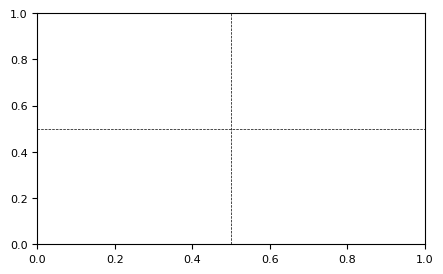

In [15]:
#plot stimulus decoding modulation by trial type

savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare-context-lick-stimulus-predict-proba-2025-09-22\figures\pdfs"

# sel_structure='MRN'
for sel_structure in trial_type_table_df['structure'].unique():
    sel_structure='MOs'

    for sel_stim_name in ['vis1','vis2','sound1','sound2']: #['vis2','sound2']:#
        if sel_stim_name in ['vis1','vis2']:
            sel_result='vis_stim_all_blocks_10units'
        elif sel_stim_name in ['sound1','sound2']:
            sel_result='aud_stim_all_blocks_10units'

        response_type=['hit','cr','fa']
        # response_type=['cr','miss']

        fig,ax=plt.subplots(1,1,figsize=(5,3))
        ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
        ax.axvline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')

        for rr, sel_response_type in enumerate(response_type):
            if sel_stim_name in ['vis1','vis2']:
                if sel_response_type=='hit':
                    sel_is_response=True
                    sel_is_vis_rewarded=True
                    label_str='hit (vis rewarded)'
                elif sel_response_type=='cr':
                    sel_is_response=False
                    sel_is_vis_rewarded=False
                    label_str='cr (aud rewarded)'
                elif sel_response_type=='fa':
                    sel_is_response=True
                    sel_is_vis_rewarded=False
                    label_str='fa (aud rewarded)'
                elif sel_response_type=='miss':
                    sel_is_response=False
                    sel_is_vis_rewarded=True
                    if '1' in sel_stim_name:
                        label_str='miss (vis rewarded)'
                    elif '2' in sel_stim_name:
                        label_str='cr (vis rewarded)'
            elif sel_stim_name in ['sound1','sound2']:
                if sel_response_type=='hit':
                    sel_is_response=True
                    sel_is_vis_rewarded=False
                    label_str='hit (aud rewarded)'
                elif sel_response_type=='cr':
                    sel_is_response=False
                    sel_is_vis_rewarded=True
                    label_str='cr (vis rewarded)'
                elif sel_response_type=='fa':
                    sel_is_response=True
                    sel_is_vis_rewarded=True
                    label_str='fa (vis rewarded)'
                elif sel_response_type=='miss':
                    sel_is_response=False
                    sel_is_vis_rewarded=False
                    if '1' in sel_stim_name:
                        label_str='miss (aud rewarded)'
                    elif '2' in sel_stim_name:
                        label_str='cr (aud rewarded)'
            if sel_response_type=='hit':
                sel_color='tab:green'
            elif sel_response_type=='cr':
                sel_color='tab:blue'
            elif sel_response_type=='fa':
                sel_color='tab:red'
            elif sel_response_type=='miss':
                sel_color='tab:orange'

            predict_proba_values=np.vstack(
                trial_type_table_df.query(
                    f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                    is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
                    results_key=="{sel_result}"')['predict_proba'].values)
            
            if '2' in sel_stim_name:
                predict_proba_values=1-predict_proba_values

            timepoints=trial_type_table_df.query(f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                                                is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
                                                results_key=="{sel_result}"')['bin_centers'].values[0].round(3)+0.025

            ax.plot(timepoints,np.nanmean(predict_proba_values,axis=0),label=label_str, color=sel_color)
            ax.fill_between(timepoints, np.nanmean(predict_proba_values,axis=0)-stats.sem(predict_proba_values,axis=0,nan_policy='omit'), 
                            np.nanmean(predict_proba_values,axis=0)+stats.sem(predict_proba_values,axis=0,nan_policy='omit'), alpha=0.3, color=sel_color)
        ax.set_title(f"{sel_structure}; stimulus:{sel_stim_name}; decode:{sel_result}\n(n={predict_proba_values.shape[0]} sessions)")
        ax.set_xlabel('time from stimulus onset (s)')
        ax.set_ylabel('decoder predict prob. of '+sel_stim_name)
        # ax.set_ylim([-0.05,1.05])
        ax.legend()

        fig.tight_layout()
        
    break
        # fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_stim_name}_decoding_by_trial_type_{sel_result}.pdf"),dpi=300)
        # plt.close(fig)


In [ ]:
#plot target vs. nontarget cr (non-rewarded blocks)

sel_structure='ACAd'
sel_modality='vis'

if sel_modality=='vis':
    sel_result='vis_stim_all_blocks'
    sel_stim_names=['vis1','vis2']
    sel_is_vis_rewarded=False
    block_type='aud'
elif sel_modality=='aud':
    sel_result='aud_stim_all_blocks'
    sel_stim_names=['sound1','sound2']
    sel_is_vis_rewarded=True
    block_type='vis'

sel_is_response=False

target_predict_proba=np.vstack(
    trial_type_table_df.query(
    f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
    is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_names[0]}" and \
    results_key=="{sel_result}"')['predict_proba'].values)

nontarget_predict_proba=np.vstack(
    trial_type_table_df.query(
    f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
    is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_names[1]}" and \
    results_key=="{sel_result}"')['predict_proba'].values)
nontarget_predict_proba=1-nontarget_predict_proba

timepoints=trial_type_table_df.query(f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                                    is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_names[0]}" and \
                                    results_key=="{sel_result}"')['bin_centers'].values[0].round(3)+0.025

fig,ax=plt.subplots(1,1,figsize=(5,3))
ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
ax.axvline(0.5,color='k',linewidth=0.5,linestyle='--')
ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')
ax.plot(timepoints,np.nanmean(target_predict_proba,axis=0),label='target (cr)', color='tab:blue')
ax.fill_between(timepoints, np.nanmean(target_predict_proba,axis=0)-stats.sem(target_predict_proba,axis=0,nan_policy='omit'), 
                np.nanmean(target_predict_proba,axis=0)+stats.sem(target_predict_proba,axis=0,nan_policy='omit'), alpha=0.3, color='tab:blue')
ax.plot(timepoints,np.nanmean(nontarget_predict_proba,axis=0),label='nontarget (cr)', color='tab:orange')
ax.fill_between(timepoints, np.nanmean(nontarget_predict_proba,axis=0)-stats.sem(nontarget_predict_proba,axis=0,nan_policy='omit'), 
                np.nanmean(nontarget_predict_proba,axis=0)+stats.sem(nontarget_predict_proba,axis=0,nan_policy='omit'), alpha=0.3, color='tab:orange')
ax.legend()
ax.set_title(f"{sel_structure}; {sel_modality} stimuli; {block_type} blocks; \n(n={target_predict_proba.shape[0]} sessions)")
ax.set_xlabel('time from stimulus onset (s)')
ax.set_ylabel('decoder predict prob. of correct stimulus')

In [ ]:
#plot nontarget fa vs cr

# sel_structure='MOs'
# sel_modality='aud'

savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare-context-lick-stimulus-predict-proba-2025-09-22\figures"

for sel_structure in trial_type_table_df['structure'].unique():
        
    for sel_modality in ['vis','aud']:

        if sel_modality=='vis':
            sel_result='vis_stim_all_blocks'
            sel_stim_name='vis2'
            sel_is_vis_rewarded=True
            block_type='vis'
        elif sel_modality=='aud':
            sel_result='aud_stim_all_blocks'
            sel_stim_name='sound2'
            sel_is_vis_rewarded=False
            block_type='aud'

        sel_is_response=[False,True]

        cr_predict_proba=1-np.vstack(
            trial_type_table_df.query(
            f'structure=="{sel_structure}" and is_response=={sel_is_response[0]} and \
            is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
            results_key=="{sel_result}"')['predict_proba'].values)

        fa_predict_proba=1-np.vstack(
            trial_type_table_df.query(
            f'structure=="{sel_structure}" and is_response=={sel_is_response[1]} and \
            is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
            results_key=="{sel_result}"')['predict_proba'].values)


        timepoints=trial_type_table_df.query(f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                                            is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_names[0]}" and \
                                            results_key=="{sel_result}"')['bin_centers'].values[0].round(3)+0.025

        fig,ax=plt.subplots(1,1,figsize=(5,3))
        ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
        ax.axvline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax.plot(timepoints,np.nanmean(cr_predict_proba,axis=0),label='cr', color='tab:blue')
        ax.fill_between(timepoints, np.nanmean(cr_predict_proba,axis=0)-stats.sem(cr_predict_proba,axis=0,nan_policy='omit'), 
                        np.nanmean(cr_predict_proba,axis=0)+stats.sem(cr_predict_proba,axis=0,nan_policy='omit'), alpha=0.3, color='tab:blue')
        ax.plot(timepoints,np.nanmean(fa_predict_proba,axis=0),label='fa', color='tab:red')
        ax.fill_between(timepoints, np.nanmean(fa_predict_proba,axis=0)-stats.sem(fa_predict_proba,axis=0,nan_policy='omit'), 
                        np.nanmean(fa_predict_proba,axis=0)+stats.sem(fa_predict_proba,axis=0,nan_policy='omit'), alpha=0.3, color='tab:red')
        ax.legend()
        ax.set_title(f"{sel_structure}; {sel_modality} nontarget; {block_type} blocks; \n(n={cr_predict_proba.shape[0]} sessions)")
        ax.set_xlabel('time from stimulus onset (s)')
        ax.set_ylabel('decoder predict prob. of nontarget stimulus')

        fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_modality}_nontarget_cr_fa_decoding_{sel_result}.png"))
        plt.close(fig)

In [ ]:
#plot difference between hit and cr - find first timepoint where hit-cr is significant + save in new table

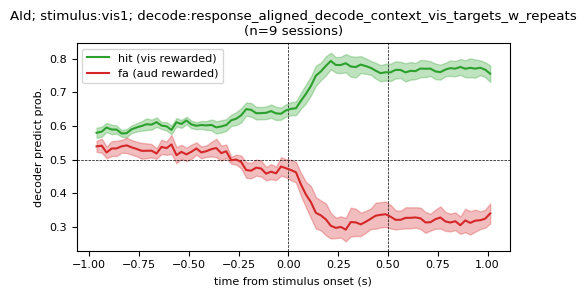

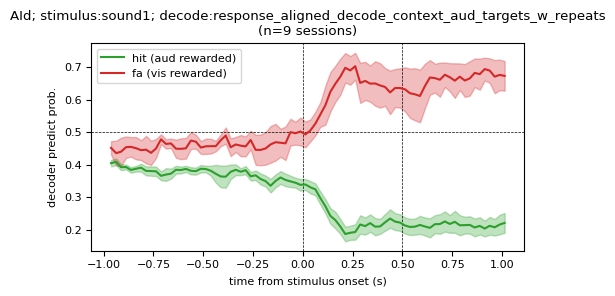

In [18]:
#plot modulation of context decoding across stimuli and trial types

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-10-30-decode_split_by_stim_modality_align_to_reward\trial_types - decode all targets together"

# sel_structure='MRN'
for sel_structure in trial_type_table_df['structure'].unique():
    sel_structure='AId'

    for sel_stim_name in ['vis1','sound1']: #['vis1','vis2','sound1','sound2']:
        # sel_result='response_all_trials_no_baseline_subtract'
        # sel_result='context_all_trials'
        # sel_result='context_no_baseline_subtract_aud_stim_10units'

        if '1' in sel_stim_name:
            # response_type=['hit','cr','fa']
            response_type=['hit','fa']
        elif '2' in sel_stim_name:
            response_type=['cr','miss']

        fig,ax=plt.subplots(1,1,figsize=(5,3))
        ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
        ax.axvline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')

        for rr, sel_response_type in enumerate(response_type):
            if sel_stim_name in ['vis1','vis2']:
                # sel_result='response_aligned_decode_context_targets_only'
                # sel_result='context_vis_stim_25ms_bins_w_repeats'
                sel_result='response_aligned_decode_context_vis_targets_w_repeats'
                if sel_response_type=='hit':
                    sel_is_response=True
                    sel_is_vis_rewarded=True
                    label_str='hit (vis rewarded)'
                elif sel_response_type=='cr':
                    sel_is_response=False
                    sel_is_vis_rewarded=False
                    label_str='cr (aud rewarded)'
                elif sel_response_type=='fa':
                    sel_is_response=True
                    sel_is_vis_rewarded=False
                    label_str='fa (aud rewarded)'
                elif sel_response_type=='miss':
                    sel_is_response=False
                    sel_is_vis_rewarded=True
                    if '1' in sel_stim_name:
                        label_str='miss (vis rewarded)'
                    elif '2' in sel_stim_name:
                        label_str='cr (vis rewarded)'
            elif sel_stim_name in ['sound1','sound2']:
                # sel_result='response_aligned_decode_context_targets_only'
                # sel_result='context_aud_stim_25ms_bins_w_repeats'
                sel_result='response_aligned_decode_context_aud_targets_w_repeats'
                if sel_response_type=='hit':
                    sel_is_response=True
                    sel_is_vis_rewarded=False
                    label_str='hit (aud rewarded)'
                elif sel_response_type=='cr':
                    sel_is_response=False
                    sel_is_vis_rewarded=True
                    label_str='cr (vis rewarded)'
                elif sel_response_type=='fa':
                    sel_is_response=True
                    sel_is_vis_rewarded=True
                    label_str='fa (vis rewarded)'
                elif sel_response_type=='miss':
                    sel_is_response=False
                    sel_is_vis_rewarded=False
                    if '1' in sel_stim_name:
                        label_str='miss (aud rewarded)'
                    elif '2' in sel_stim_name:
                        label_str='cr (aud rewarded)'
            if sel_response_type=='hit':
                sel_color='tab:green'
            elif sel_response_type=='cr':
                sel_color='tab:blue'
            elif sel_response_type=='fa':
                sel_color='tab:red'
            elif sel_response_type=='miss':
                sel_color='tab:orange'

            temp_stack=trial_type_table_df.query(
                    f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                    is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
                    results_key=="{sel_result}"')['predict_proba'].values
            if len(temp_stack)==0:
                print(f"no data for {sel_structure}, {sel_stim_name}, {sel_response_type}, {sel_result}")
                continue
            else:
                predict_proba_values=np.vstack(temp_stack)
            
            # if sel_is_vis_rewarded==False:
            #     predict_proba_values=1-predict_proba_values
            
            # if '2' in sel_stim_name:
            #     predict_proba_values=1-predict_proba_values

            timepoints=trial_type_table_df.query(f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                                                is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
                                                results_key=="{sel_result}"')['bin_centers'].values[0].round(3)+0.025

            ax.plot(timepoints,np.nanmean(predict_proba_values,axis=0),label=label_str, color=sel_color)
            ax.fill_between(timepoints, np.nanmean(predict_proba_values,axis=0)-stats.sem(predict_proba_values,axis=0,nan_policy='omit'), 
                            np.nanmean(predict_proba_values,axis=0)+stats.sem(predict_proba_values,axis=0,nan_policy='omit'), alpha=0.3, color=sel_color)
        ax.set_title(f"{sel_structure}; stimulus:{sel_stim_name}; decode:{sel_result}\n(n={predict_proba_values.shape[0]} sessions)")
        ax.set_xlabel('time from stimulus onset (s)')
        ax.set_ylabel('decoder predict prob.')
        # ax.set_ylim([0.2,0.8])
        ax.legend()

        fig.tight_layout()
        
        # fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_stim_name}_decoding_by_trial_type_{sel_result}.png"))
        # plt.close(fig)
    break


In [ ]:
# temp_stack
trial_type_table_df.query(
                    f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                    is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
                    results_key=="{sel_result}"')

In [ ]:
### high confidence vs. low confidence hit trials? Match low confidence hit trials to fa trials, then plot how outcome differentially affects predict proba?

### needs different trial averaging strategy

In [ ]:
### NEXT STEPS:

# quantify/plot differences between some of these conditions



In [17]:
trial_type_table_df

,results_key,session_id,structure,predict_proba,bin_centers,unit_subsample_size,time_aligned_to,trial_index,is_response,is_vis_rewarded,stim_name,n_trials,session_dprime,n_passing_vis_blocks,n_passing_aud_blocks
0,aud_pref_units_decode_licks,742903_2024-10-22,CP,"[0.4747791567450052, 0.4814427770686771, 0.485...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,"[91, 164, 168, 172, 275, 284, 339, 463, 477, 5...",True,True,sound1,12,2.417863,2,3
1,aud_pref_units_decode_licks,742903_2024-10-22,CP,"[0.48739259598655776, 0.49427874443258785, 0.5...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,"[92, 103, 108, 112, 117, 119, 120, 124, 134, 1...",False,True,sound1,47,2.417863,2,3
2,aud_pref_units_decode_licks,742903_2024-10-22,CP,"[0.45708238387460925, 0.4461950721518064, 0.48...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,[293],True,True,sound2,1,2.417863,2,3
3,aud_pref_units_decode_licks,742903_2024-10-22,CP,"[0.4844841206349071, 0.48687893939090476, 0.48...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,"[93, 95, 97, 99, 110, 115, 126, 130, 131, 132,...",False,True,sound2,58,2.417863,2,3
4,aud_pref_units_decode_licks,742903_2024-10-22,CP,"[0.48779009505938853, 0.49296339871296285, 0.4...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,"[94, 98, 105, 106, 107, 114, 116, 118, 123, 13...",True,True,vis1,49,2.417863,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,vis_pref_units_decode_licks,742903_2024-10-22,SSs,"[0.5023674568373244, 0.5070156018491812, 0.509...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,"[13, 14, 16, 22, 28, 32, 43, 46, 47, 61, 63, 6...",False,False,vis1,47,2.417863,2,3
296,vis_pref_units_decode_licks,742903_2024-10-22,SSs,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,[],True,False,vis2,0,2.417863,2,3
297,vis_pref_units_decode_licks,742903_2024-10-22,SSs,"[0.5067587284580779, 0.5077712565847385, 0.504...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,"[8, 10, 17, 21, 23, 27, 33, 36, 44, 45, 52, 59...",False,False,vis2,56,2.417863,2,3
298,vis_pref_units_decode_licks,742903_2024-10-22,SSs,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,[],True,False,catch,0,2.417863,2,3


c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encounte

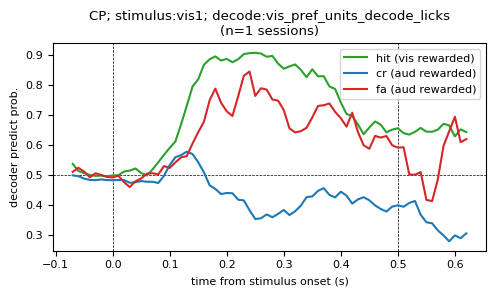

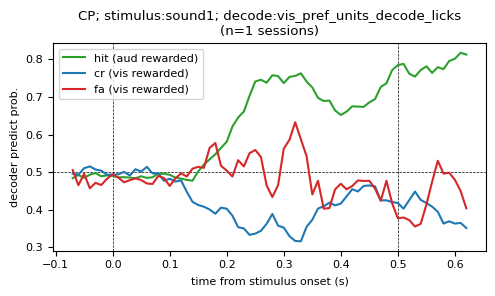

In [23]:
### plots for lick decoding ###
#using aud pref units vs. vis pref units

#plot modulation of context decoding across stimuli and trial types

# savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-10-30-decode_split_by_stim_modality_align_to_reward\trial_types - decode all targets together"

sel_result='vis_pref_units_decode_licks'

# sel_structure='MRN'
for sel_structure in trial_type_table_df['structure'].unique():
    sel_structure='CP'

    for sel_stim_name in ['vis1','sound1']: #['vis1','vis2','sound1','sound2']:
        # sel_result='response_all_trials_no_baseline_subtract'
        # sel_result='context_all_trials'
        # sel_result='context_no_baseline_subtract_aud_stim_10units'

        if '1' in sel_stim_name:
            response_type=['hit','cr','fa']
            # response_type=['hit','fa']
        elif '2' in sel_stim_name:
            response_type=['cr','miss']

        fig,ax=plt.subplots(1,1,figsize=(5,3))
        ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
        ax.axvline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')

        for rr, sel_response_type in enumerate(response_type):
            if sel_stim_name in ['vis1','vis2']:
                # sel_result='response_aligned_decode_context_targets_only'
                # sel_result='context_vis_stim_25ms_bins_w_repeats'
                # sel_result='response_aligned_decode_context_vis_targets_w_repeats'
                if sel_response_type=='hit':
                    sel_is_response=True
                    sel_is_vis_rewarded=True
                    label_str='hit (vis rewarded)'
                elif sel_response_type=='cr':
                    sel_is_response=False
                    sel_is_vis_rewarded=False
                    label_str='cr (aud rewarded)'
                elif sel_response_type=='fa':
                    sel_is_response=True
                    sel_is_vis_rewarded=False
                    label_str='fa (aud rewarded)'
                elif sel_response_type=='miss':
                    sel_is_response=False
                    sel_is_vis_rewarded=True
                    if '1' in sel_stim_name:
                        label_str='miss (vis rewarded)'
                    elif '2' in sel_stim_name:
                        label_str='cr (vis rewarded)'
            elif sel_stim_name in ['sound1','sound2']:
                # sel_result='response_aligned_decode_context_targets_only'
                # sel_result='context_aud_stim_25ms_bins_w_repeats'
                # sel_result='response_aligned_decode_context_aud_targets_w_repeats'
                if sel_response_type=='hit':
                    sel_is_response=True
                    sel_is_vis_rewarded=False
                    label_str='hit (aud rewarded)'
                elif sel_response_type=='cr':
                    sel_is_response=False
                    sel_is_vis_rewarded=True
                    label_str='cr (vis rewarded)'
                elif sel_response_type=='fa':
                    sel_is_response=True
                    sel_is_vis_rewarded=True
                    label_str='fa (vis rewarded)'
                elif sel_response_type=='miss':
                    sel_is_response=False
                    sel_is_vis_rewarded=False
                    if '1' in sel_stim_name:
                        label_str='miss (aud rewarded)'
                    elif '2' in sel_stim_name:
                        label_str='cr (aud rewarded)'
            if sel_response_type=='hit':
                sel_color='tab:green'
            elif sel_response_type=='cr':
                sel_color='tab:blue'
            elif sel_response_type=='fa':
                sel_color='tab:red'
            elif sel_response_type=='miss':
                sel_color='tab:orange'

            temp_stack=trial_type_table_df.query(
                    f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                    is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
                    results_key=="{sel_result}"')['predict_proba'].values
            if len(temp_stack)==0:
                print(f"no data for {sel_structure}, {sel_stim_name}, {sel_response_type}, {sel_result}")
                continue
            else:
                predict_proba_values=np.vstack(temp_stack)
            
            # if sel_is_vis_rewarded==False:
            #     predict_proba_values=1-predict_proba_values
            
            # if '2' in sel_stim_name:
            #     predict_proba_values=1-predict_proba_values

            timepoints=trial_type_table_df.query(f'structure=="{sel_structure}" and is_response=={sel_is_response} and \
                                                is_vis_rewarded=={sel_is_vis_rewarded} and stim_name=="{sel_stim_name}" and \
                                                results_key=="{sel_result}"')['bin_centers'].values[0].round(3)+0.025

            ax.plot(timepoints,np.nanmean(predict_proba_values,axis=0),label=label_str, color=sel_color)
            ax.fill_between(timepoints, np.nanmean(predict_proba_values,axis=0)-stats.sem(predict_proba_values,axis=0,nan_policy='omit'), 
                            np.nanmean(predict_proba_values,axis=0)+stats.sem(predict_proba_values,axis=0,nan_policy='omit'), alpha=0.3, color=sel_color)
        ax.set_title(f"{sel_structure}; stimulus:{sel_stim_name}; decode:{sel_result}\n(n={predict_proba_values.shape[0]} sessions)")
        ax.set_xlabel('time from stimulus onset (s)')
        ax.set_ylabel('decoder predict prob.')
        # ax.set_ylim([0.2,0.8])
        ax.legend()

        fig.tight_layout()
        
        # fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_stim_name}_decoding_by_trial_type_{sel_result}.png"))
        # plt.close(fig)
    break


In [ ]:
### bin by baseline predict proba, not different trial types



In [ ]:
#plot context decoding modulation by stimulus name

In [ ]:
# use null shift to compare? (nope, I don't save predict proba for shifts)

In [ ]:
# correlate predict proba across different results?
results_dfs.keys()

In [ ]:
sel_bin_center=0.075
sel_structure='ACAd'
sel_session='664851_2023-11-13'

key1='context_all_trials'
key2='context_all_trials_no_baseline_subtract'
# key2='response_all_trials_no_baseline_subtract'


results_dfs[key1]['bin_center']=np.round(results_dfs[key1]['bin_center'],3)
results_dfs[key2]['bin_center']=np.round(results_dfs[key2]['bin_center'],3)

result1=results_dfs[key1].query('bin_center==@sel_bin_center and structure==@sel_structure and session_id==@sel_session').sort_values('session_id')
result2=results_dfs[key2].query('bin_center==@sel_bin_center and structure==@sel_structure and session_id==@sel_session').sort_values('session_id')

r,p=stats.pearsonr(result1['predict_proba'].values[0], result2['predict_proba'].values[0])
print(f"Pearson r: {r:.3f}, p-value: {p:.3f}")

fig,ax=plt.subplots(1,1,figsize=(8,4))
# ax.scatter(result1['predict_proba'].values[0], result2['predict_proba'].values[0])
ax.plot(result1['predict_proba'].values[0],alpha=0.5,linewidth=1)
ax.plot(result2['predict_proba'].values[0],alpha=0.5,linewidth=1)
ax.set_xlabel('trials')
ax.set_ylabel('predict_proba')
ax.set_title(f"{key1} vs {key2};\n {sel_structure}; {sel_session}; bin center: {sel_bin_center}s\nPearson r: {r:.3f}, p-value: {p:.3f}")

In [ ]:
sel_bin_center=-0.075
sel_structure_1='ACAd'
sel_structure_2='SCm'
sel_session='664851_2023-11-13'
sel_key='context_all_trials_no_baseline_subtract'
# sel_key='vis_stim_all_blocks'
# sel_key='response_all_trials_no_baseline_subtract'

results_dfs[sel_key]['bin_center']=np.round(results_dfs[sel_key]['bin_center'],3)

result1=results_dfs[sel_key].query('bin_center==@sel_bin_center and structure==@sel_structure_1 and session_id==@sel_session').sort_values('session_id')
result2=results_dfs[sel_key].query('bin_center==@sel_bin_center and structure==@sel_structure_2 and session_id==@sel_session').sort_values('session_id')

r,p=stats.pearsonr(result1['predict_proba'].values[0], result2['predict_proba'].values[0])
print(f"Pearson r: {r:.3f}, p-value: {p:.3f}")

fig,ax=plt.subplots(1,1,figsize=(8,4))
# ax.scatter(result1['predict_proba'].values[0], result2['predict_proba'].values[0])
ax.plot(result1['predict_proba'].values[0],alpha=0.5,linewidth=1)
ax.plot(result2['predict_proba'].values[0],alpha=0.5,linewidth=1)
ax.set_xlabel('trials')
ax.set_ylabel('predict_proba')
ax.set_title(f"{sel_structure_1} vs {sel_structure_2};\n {sel_session}; bin center: {sel_bin_center}s\nPearson r: {r:.3f}, p-value: {p:.3f}")

In [ ]:
#select 2 structures
# sel_structure_1='ORBl'
# sel_structure_2='ACAd'
# sel_session='664851_2023-11-13'

sel_key='context_all_trials_no_baseline_subtract'
# sel_key='context_500ms_bins'

correction = 'flip_aud' # 'flip_aud', 'subtract_mean', 'none'
excl_instruction_trials = True

#correlate predict proba at each timepoint across trials
results_dfs[sel_key]['bin_center']=np.round(results_dfs[sel_key]['bin_center'],3)

predict_proba_corr_by_bin_center={
    'structure_1':[],
    'structure_2':[],
    'session_id':[],
    'results_key':[],
    'bin_center':[],
    'pearson_r':[],
    'p_value':[],
}

#loop through sessions
for sel_session in results_dfs[sel_key]['session_id'].unique():
    if sel_session not in dr_session_list:
        print(f"session {sel_session} not in dr_session_list; skipping")
        continue
    session_df=results_dfs[sel_key].query('session_id==@sel_session')
    session_trials=all_trials.to_pandas().query(f'session_id=="{sel_session}"')
    session_trials['choice_predict_proba']=np.nan
    #false alarms
    session_trials.loc[
        (session_trials['is_response']==True) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
        (session_trials['is_response']==True) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
        ,'choice_predict_proba']=-1
    #correct rejects
    session_trials.loc[
        (session_trials['is_response']==False) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
        (session_trials['is_response']==False) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
        ,'choice_predict_proba']=1
    # choice_vector=session_trials.sort_values('trial_index')['choice_predict_proba'].values

    structure_list=np.concatenate([session_df['structure'].unique(),np.array(['choice'])])

    for sel_bin_center in session_df['bin_center'].unique():
        for sel_structure in session_df.query('bin_center==@sel_bin_center')['structure'].unique():
            temp_combined_trials=session_trials.copy()
            
            temp_predict_proba=session_df.query('bin_center==@sel_bin_center and structure==@sel_structure')['predict_proba'].values[0]

            if len(temp_predict_proba)!=temp_combined_trials.shape[0]:
                print('warning! predict_proba length does not match number of trials, skipping '+sel_structure+' session '+sel_session+' bin center '+str(sel_bin_center))
                continue
            temp_combined_trials['predict_proba']=temp_predict_proba

            corrected_predict_proba = []
            for bb in temp_combined_trials['block_index'].unique():
                block_trials=temp_combined_trials.query(f'block_index=={bb}')
                if correction=='flip_aud':
                    if block_trials['rewarded_modality'].values[0]=='vis':
                        corrected_predict_proba.append(block_trials['predict_proba'].values)
                    elif block_trials['rewarded_modality'].values[0]=='aud':
                        corrected_predict_proba.append(1 - block_trials['predict_proba'].values)
                elif correction=='subtract_mean':
                    corrected_predict_proba.append(block_trials['predict_proba'].values - np.nanmean(block_trials['predict_proba'].values))
                elif correction=='none':
                    corrected_predict_proba.append(block_trials['predict_proba'].values)

            corrected_predict_proba = np.concatenate(corrected_predict_proba)

            session_trials[f'{sel_structure}_predict_proba_{sel_bin_center}']=corrected_predict_proba

        session_trials[f'choice_predict_proba_{sel_bin_center}']=session_trials['choice_predict_proba']

    if excl_instruction_trials:
        session_trials=session_trials.query('~is_instruction').reset_index(drop=True) 

    #loop through unique bin centers
    for sel_bin_center in session_df['bin_center'].unique():
        
        #get unique combinations of areas
        for sel_structure_1 in structure_list:
            for sel_structure_2 in ['choice']:#structure_list:
                if sel_structure_1 == sel_structure_2:
                    continue
            
                # if sel_structure_1=='choice':
                #     result1=choice_vector
                # else:
                #     result1=session_df.query('bin_center==@sel_bin_center and structure==@sel_structure_1')['predict_proba'].values[0]
                # if sel_structure_2=='choice':
                #     result2=choice_vector
                # else:
                #     result2=session_df.query('bin_center==@sel_bin_center and structure==@sel_structure_2')['predict_proba'].values[0]
                
                if f'{sel_structure_1}_predict_proba_{sel_bin_center}' not in session_trials.columns:
                    print(f'warning! {sel_structure_1}_predict_proba not in session_trials columns, skipping '+sel_structure_1+' and '+sel_structure_2+' session '+sel_session+' bin center '+str(sel_bin_center))
                    continue
                if f'{sel_structure_2}_predict_proba_{sel_bin_center}' not in session_trials.columns:
                    print(f'warning! {sel_structure_2}_predict_proba not in session_trials columns, skipping '+sel_structure_1+' and '+sel_structure_2+' session '+sel_session+' bin center '+str(sel_bin_center))
                    continue
                result1=session_trials[f'{sel_structure_1}_predict_proba_{sel_bin_center}'].values
                result2=session_trials[f'{sel_structure_2}_predict_proba_{sel_bin_center}'].values

                if len(result1)!=len(result2):
                    print('warning! result1 and result2 have different lengths, skipping '+sel_structure_1+' and '+sel_structure_2+' session '+sel_session+' bin center '+str(sel_bin_center))
                    continue
                #exclude nans
                valid_indices=~(np.isnan(result1) | np.isnan(result2))

                r,p=stats.pearsonr(result1[valid_indices], result2[valid_indices])

                # print(f"Bin center: {sel_bin_center}s; Pearson r: {r:.3f}, p-value: {p:.3f}")

                predict_proba_corr_by_bin_center['structure_1'].append(sel_structure_1)
                predict_proba_corr_by_bin_center['structure_2'].append(sel_structure_2)
                predict_proba_corr_by_bin_center['session_id'].append(sel_session)
                predict_proba_corr_by_bin_center['results_key'].append(sel_key)
                predict_proba_corr_by_bin_center['bin_center'].append(sel_bin_center)
                predict_proba_corr_by_bin_center['pearson_r'].append(r)
                predict_proba_corr_by_bin_center['p_value'].append(p)
    break


# predict_proba_corr_by_bin_center_df=pd.DataFrame(predict_proba_corr_by_bin_center)

In [ ]:
predict_proba_corr_by_bin_center_df
# session_trials
# choice_vector.shape
# result1.shape
# valid_indices.shape
# len(result2[valid_indices])

In [ ]:
savepath=r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\predict_proba_corr_across_bin_centers_2025-10-01'
predict_proba_corr_by_bin_center_df.to_parquet(os.path.join(savepath, "predict_proba_corr_across_bin_centers_"+sel_key+"_choice_corrected.parquet"))

In [ ]:
# loadpath=r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\predict_proba_corr_across_bin_centers_2025-10-01\\'
# predict_proba_corr_by_bin_center_df=pl.scan_parquet(loadpath).collect().to_pandas()

In [ ]:
loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\predict_proba_corr_across_bin_centers_2025-10-01\predict_proba_corr_across_bin_centers_context_500ms_bins_choice.parquet"
predict_proba_corr_by_bin_center_df=pl.scan_parquet(loadpath).collect().to_pandas()

In [ ]:
predict_proba_corr_by_bin_center_df

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,3))
ax.axhline(0,color='k',linewidth=0.5,linestyle='--')
ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
ax.plot(predict_proba_corr_by_bin_center_df['bin_center']+0.025, predict_proba_corr_by_bin_center_df['pearson_r'], marker='.')
ax.set_xlabel('bin center (s)')
ax.set_ylabel('Pearson r')

In [ ]:
#compare correlation values across different structure pairs
structure1='MOs'
structure2='choice'

sel_key='context_all_trials_no_baseline_subtract'

corr_by_session=[]

pair_df=predict_proba_corr_by_bin_center_df.query('structure_1==@structure1 and structure_2==@structure2 and results_key==@sel_key')

for sel_session in pair_df['session_id'].unique():
    temp_session_df=pair_df.query('session_id==@sel_session').sort_values('bin_center')
    if temp_session_df.shape[0]==0:
        continue
    corr_by_session.append(temp_session_df['pearson_r'].values)

corr_by_session=np.vstack(corr_by_session)

bins=np.round(pair_df['bin_center'].unique(),3)+0.025

fig,ax=plt.subplots(1,1,figsize=(5,3))
ax.axhline(0,color='k',linewidth=0.5,linestyle='--')
ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
ax.plot(bins, corr_by_session.T, color='gray', alpha=0.3)
ax.plot(bins, np.nanmean(corr_by_session,axis=0),'k')
ax.set_xlabel('bin center (s)')
ax.set_ylabel('Pearson r')
ax.set_title(f"{structure1} vs {structure2}; {sel_key}\n(n={corr_by_session.shape[0]} sessions)")

In [ ]:
#plot list of areas against single area

# sel_structure='SCm'

# struct_list=['SCm','MRN','CP','MOs','AId','ACAd','FRP','ORBl','PL','ILA','SSp','MOp','VISp','CA1','MD','RT','choice',]
struct_list=['SCm','MRN','CP','MOs','AId','ACAd','FRP','ORBl','PL','choice',]
# struct_list=['SCm','MRN','CP','MOs','MOp','SSp','AId','ACAd','FRP','ORBl','VTA','GPe','RT','MD','choice',]
# struct_list=['VISp','AUDp','LGd','MGd','MD','RT','VAL']
# struct_list=['choice']

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-10-01-decoding_latency"

color_list=plt.cm.tab10.colors

sel_key='context_all_trials_no_baseline_subtract'

for sel_structure in struct_list:
    sel_structure='choice'
    n_list=[]

    fig,ax=plt.subplots(1,1,figsize=(5.5,3))
    ax.axhline(0,color='k',linewidth=0.5,linestyle='--')
    ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
    for ss,sel_structure_2 in enumerate(struct_list):
        if sel_structure_2 == sel_structure:
            continue
        pair_df=predict_proba_corr_by_bin_center_df.query('structure_2==@sel_structure and structure_1==@sel_structure_2 and results_key==@sel_key')

        corr_by_session=[]

        for sel_session in pair_df['session_id'].unique():
            temp_session_df=pair_df.query('session_id==@sel_session').sort_values('bin_center')
            if temp_session_df.shape[0]==0:
                continue
            corr_by_session.append(temp_session_df['pearson_r'].values)

        if len(corr_by_session)<=1:
            continue

        corr_by_session=np.vstack(corr_by_session)

        bins=np.round(pair_df['bin_center'].unique(),3)+0.025

        if ss<len(color_list):
            line_style='-'
        if ss>len(color_list)-1:
            ss=ss-len(color_list)
            line_style='--'

        ax.plot(bins, np.nanmean(corr_by_session,axis=0), label=sel_structure_2+f' ({corr_by_session.shape[0]})', color=color_list[ss], linestyle=line_style)
    ax.set_xlabel('bin center (s)')
    ax.set_ylabel('Pearson r')
    # ax.set_ylim([0.1,0.9])
    # ax.set_xlim([-0.05,0.25])
    ax.set_title(f"{sel_structure} vs other areas; {sel_key}")
    ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
    fig.tight_layout()
    fig.savefig(os.path.join(savepath, f"{sel_structure}_vs_other_areas_{sel_key}.png"), dpi=300)
    break


In [ ]:
len(color_list)
plt.cm.tab10.colors